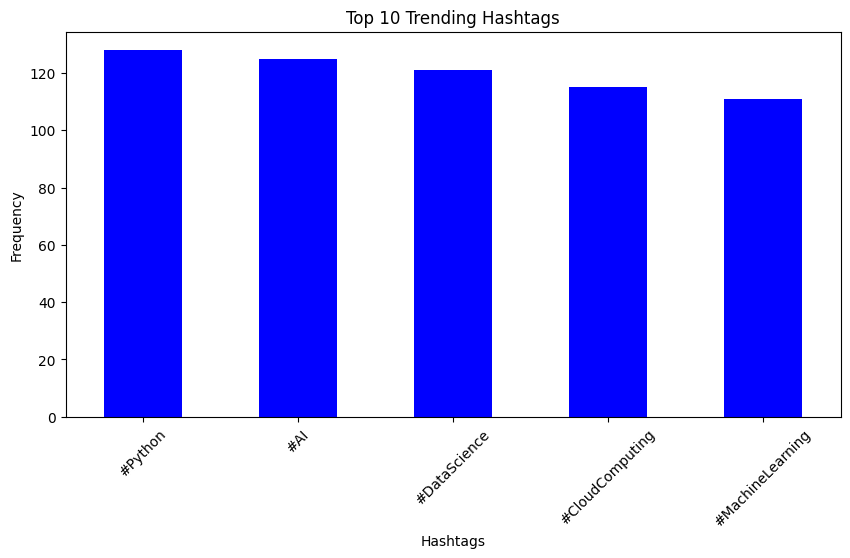

Accuracy: 0.5375
              precision    recall  f1-score   support

         0.0       0.62      0.31      0.41        42
         1.0       0.51      0.79      0.62        38

    accuracy                           0.54        80
   macro avg       0.56      0.55      0.52        80
weighted avg       0.57      0.54      0.51        80



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("social_media_behavior_dataset.csv")

# Handling missing values
df = df.dropna(subset=['Post Content', 'Sentiment', 'Hashtag'])  # Drop rows with NaN in key columns

# Trending Posts Analyzer
trending_hashtags = df['Hashtag'].value_counts().head(10)  # Top 10 hashtags

# Visualizing
plt.figure(figsize=(10, 5))
trending_hashtags.plot(kind='bar', color='blue')
plt.title('Top 10 Trending Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Sentiment Analysis Model
# Preprocessing
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})  # Convert to binary

# Drop remaining NaN values in 'Sentiment' after mapping
df = df.dropna(subset=['Sentiment'])

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df['Post Content'], df['Sentiment'], test_size=0.2, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model Training
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_vec, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_vec)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.5625
              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57        42
         1.0       0.54      0.58      0.56        38

    accuracy                           0.56        80
   macro avg       0.56      0.56      0.56        80
weighted avg       0.56      0.56      0.56        80



In [7]:
import pandas as pd
import openai
import time
import os
import torch
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Load API Key
load_dotenv()
openai.api_key = os.getenv("YOUR_OPENAI_API_KEY")

# Load dataset
df = pd.read_csv("social_media_behavior_dataset.csv")

# Handling missing values
df = df.dropna(subset=['Post Content', 'Sentiment'])

# Mapping sentiment to binary labels
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})
df = df.dropna(subset=['Sentiment'])

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df['Post Content'], df['Sentiment'], test_size=0.2, random_state=42)

# Load DistilBERT model & tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {key: val.squeeze(0) for key, val in encoding.items()}, label

# Prepare dataset & dataloader
test_dataset = SentimentDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def classify_with_openai(text):
    prompt = f"Analyze the sentiment of the following social media post as either 'Positive' or 'Negative'.\n\nPost: {text}\n\nSentiment:"
    
    try:
        response = openai.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are an AI that classifies social media posts as 'Positive' or 'Negative'."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        sentiment = response.choices[0].message.content.strip()
        return 1 if "Positive" in sentiment else 0
    except Exception as e:
        print("Error:", e)
        return None

# Predict using hybrid model
y_pred = []
gpt_used = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).cpu().numpy()
        
        confidence_scores = probs.max(dim=-1).values.cpu().numpy()
        
        for i, confidence in enumerate(confidence_scores):
            idx = len(y_pred)  # Current index
            if confidence < 0.6 and idx < len(X_test):  # Use GPT-4 for low-confidence cases
                gpt_used += 1
                gpt_pred = classify_with_openai(X_test.iloc[idx])
                preds[i] = gpt_pred if gpt_pred is not None else preds[i]
                time.sleep(1)  # Avoid hitting API rate limits
            
            y_pred.append(preds[i])

# Evaluation
print("Accuracy:", accuracy_score(y_test[:len(y_pred)], y_pred))
print(classification_report(y_test[:len(y_pred)], y_pred))
print(f"GPT-4 was used for {gpt_used} instances.")


d:\Hack-Nocturne-2025\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.5
              precision    recall  f1-score   support

         0.0       0.55      0.29      0.38        42
         1.0       0.48      0.74      0.58        38

    accuracy                           0.50        80
   macro avg       0.51      0.51      0.48        80
weighted avg       0.52      0.50      0.47        80

GPT-4 was used for 80 instances.


In [8]:
import pandas as pd

# Load the dataset
file_path = "social_media_behavior_dataset.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          600 non-null    object
 1   Platform      600 non-null    object
 2   Hashtag       600 non-null    object
 3   Post Content  600 non-null    object
 4   Sentiment     600 non-null    object
 5   Likes         600 non-null    int64 
 6   Shares        600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB


(None,
          Date   Platform          Hashtag  \
 0  2024-02-12    Twitter  #CloudComputing   
 1  2024-09-17  Instagram              #AI   
 2  2024-02-28    Twitter              #AI   
 3  2024-05-29    Twitter          #Python   
 4  2024-01-14    Twitter  #CloudComputing   
 
                                         Post Content Sentiment  Likes  Shares  
 0  Can anyone recommend good resources for #Cloud...  Positive    254      28  
 1    Not sure I understand #AI. Can someone explain?  Positive    466      51  
 2    Not sure I understand #AI. Can someone explain?  Negative    169      61  
 3   Can anyone recommend good resources for #Python?  Positive     89     140  
 4  Not sure I understand #CloudComputing. Can som...  Positive    191     191  )

In [9]:
# Resolve conflicting labels by keeping the most frequent sentiment
df_cleaned = df.groupby("Post Content")["Sentiment"].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Keep only relevant columns
df_cleaned = df_cleaned.merge(df[['Post Content', 'Likes', 'Shares']], on='Post Content', how='left').drop_duplicates()

# Display cleaned dataset info
df_cleaned.info(), df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Post Content  600 non-null    object
 1   Sentiment     600 non-null    object
 2   Likes         600 non-null    int64 
 3   Shares        600 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 18.9+ KB


(None,
                                    Post Content Sentiment  Likes  Shares
 0  Can anyone recommend good resources for #AI?   Neutral    433       9
 1  Can anyone recommend good resources for #AI?   Neutral    351      85
 2  Can anyone recommend good resources for #AI?   Neutral      2      58
 3  Can anyone recommend good resources for #AI?   Neutral    488     176
 4  Can anyone recommend good resources for #AI?   Neutral     17      91)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "social_media_behavior_dataset.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          600 non-null    object
 1   Platform      600 non-null    object
 2   Hashtag       600 non-null    object
 3   Post Content  600 non-null    object
 4   Sentiment     600 non-null    object
 5   Likes         600 non-null    int64 
 6   Shares        600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB


(None,
          Date   Platform          Hashtag  \
 0  2024-02-12    Twitter  #CloudComputing   
 1  2024-09-17  Instagram              #AI   
 2  2024-02-28    Twitter              #AI   
 3  2024-05-29    Twitter          #Python   
 4  2024-01-14    Twitter  #CloudComputing   
 
                                         Post Content Sentiment  Likes  Shares  
 0  Can anyone recommend good resources for #Cloud...  Positive    254      28  
 1    Not sure I understand #AI. Can someone explain?  Positive    466      51  
 2    Not sure I understand #AI. Can someone explain?  Negative    169      61  
 3   Can anyone recommend good resources for #Python?  Positive     89     140  
 4  Not sure I understand #CloudComputing. Can som...  Positive    191     191  )

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
# Simplified tokenization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Simplified Text Cleaning Function
def advanced_text_cleaning(text):
    """
    Advanced text preprocessing function with simplified tokenization
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Try to download stopwords, if not available use a basic list
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        nltk.download('stopwords', quiet=True)
        try:
            stop_words = set(stopwords.words('english'))
        except:
            stop_words = {'the', 'a', 'an', 'in', 'to', 'for', 'of', 'and', 'or', 'but'}
    
    # Tokenize by splitting on whitespace
    tokens = text.split()
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Model Training and Evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple machine learning models
    """
    # Enhanced model list with Gradient Boosting
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(kernel='linear', probability=True, class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
    }
    
    # Results storage
    model_results = {}
    
    # Model training and evaluation
    for name, model in models.items():
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
            ('classifier', model)
        ])
        
        # Fit on full training data
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Store results
        model_results[name] = {
            'accuracy': accuracy,
            'classification_report': report
        }
        
        print(f'\n{name} Performance:')
        print(f'Accuracy: {accuracy:.4f}')
        print('Classification Report:\n', report)
    
    # Find best model
    best_model = max(model_results, key=lambda x: model_results[x]['accuracy'])
    
    return model_results, best_model

# Main Execution
def main():
    # Load dataset
    try:
        df = pd.read_csv('social_media_behavior_dataset.csv')
    except FileNotFoundError:
        print("Error: Dataset file not found. Please check the file path.")
        return
    
    # Drop duplicates & missing values
    df.drop_duplicates(inplace=True)
    df.dropna(subset=['Post Content', 'Sentiment'], inplace=True)
    
    # Text Cleaning
    df['Cleaned Content'] = df['Post Content'].apply(advanced_text_cleaning)
    
    # Encode Labels
    le = LabelEncoder()
    df['Sentiment_Encoded'] = le.fit_transform(df['Sentiment'])
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        df['Cleaned Content'], 
        df['Sentiment_Encoded'], 
        test_size=0.2, 
        stratify=df['Sentiment_Encoded'], 
        random_state=42
    )
    
    # Train and Evaluate Models
    model_results, best_model = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    print(f'\nBest Model: {best_model}')

if __name__ == '__main__':
    main()


Logistic Regression Performance:
Accuracy: 0.3250
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.32      0.34        38
           1       0.29      0.38      0.33        40
           2       0.33      0.29      0.31        42

    accuracy                           0.33       120
   macro avg       0.33      0.33      0.33       120
weighted avg       0.33      0.33      0.32       120


SVM Performance:
Accuracy: 0.3167
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.34      0.35        38
           1       0.28      0.42      0.34        40
           2       0.35      0.19      0.25        42

    accuracy                           0.32       120
   macro avg       0.33      0.32      0.31       120
weighted avg       0.33      0.32      0.31       120


Naive Bayes Performance:
Accuracy: 0.3333
Classification Report:
               precision    recall  f1

In [12]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load and clean dataset
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.drop_duplicates(subset=["Post Content"], keep="first", inplace=True)
    df = df[df['Sentiment'].isin(["Positive", "Negative", "Neutral"])]
    return df

# Tokenization & Encoding
def prepare_data(df, tokenizer, max_length=128):
    encodings = tokenizer(
        df["Post Content"].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )
    label_encoder = LabelEncoder()
    labels = torch.tensor(label_encoder.fit_transform(df["Sentiment"]))
    return encodings['input_ids'], encodings['attention_mask'], labels, label_encoder

# Training function
def train_model(train_loader, model, optimizer, device):
    model.train()
    for batch in train_loader:
        input_ids, attention_masks, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate_model(test_loader, model, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return true_labels, predictions

# Main execution
def main():
    file_path = 'social_media_behavior_dataset.csv'  # Update path if needed
    df_cleaned = load_and_clean_data(file_path)
    
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    input_ids, attention_masks, labels, label_encoder = prepare_data(df_cleaned, tokenizer)
    
    X_train, X_test, y_train, y_test, train_masks, test_masks = train_test_split(
        input_ids, labels, attention_masks, test_size=0.2, random_state=42, stratify=labels
    )
    
    train_dataset = TensorDataset(X_train, train_masks, y_train)
    test_dataset = TensorDataset(X_test, test_masks, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    for epoch in range(13):
        print(f"Epoch {epoch + 1}/13")
        train_model(train_loader, model, optimizer, device)
    
    true_labels, predictions = evaluate_model(test_loader, model, device)
    print("Accuracy:", accuracy_score(true_labels, predictions))
    print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

if __name__ == '__main__':
    main()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/13
Epoch 2/13
Epoch 3/13
Epoch 4/13
Epoch 5/13
Epoch 6/13
Epoch 7/13
Epoch 8/13
Epoch 9/13
Epoch 10/13
Epoch 11/13
Epoch 12/13
Epoch 13/13
Accuracy: 0.8
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
     Neutral       1.00      0.50      0.67         2
    Positive       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.89      0.83      0.82         5
weighted avg       0.87      0.80      0.79         5



In [13]:
import torch

# Save the model
model_path = "sentiment_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to sentiment_model.pth


In [14]:
import pandas as pd

# Load the Reddit dataset (JSON format)
file_path = "dataset_reddit-scraper_2025-03-28_14-00-20-789.json"
df_reddit = pd.read_json(file_path)

# Display the first few rows and check column names
df_reddit.head(), df_reddit.columns

(           id parsedId                             title    communityName  \
 0  t3_1jlvnxy  1jlvnxy               Are you interested?  r/cybersecurity   
 1  t3_1jlv82g  1jlv82g  Disheartened after SOC interview  r/cybersecurity   
 2  t1_mk6mhhv  mk6mhhv                               NaN  r/cybersecurity   
 3  t1_mk6m8dh  mk6m8dh                               NaN  r/cybersecurity   
 4  t1_mk6mv8y  mk6mv8y                               NaN  r/cybersecurity   
 
   parsedCommunityName                                               body  \
 0       cybersecurity  Hey,\n\nWe’re building a dedicated network for...   
 1       cybersecurity  Hey all.  I recently had a L1 SOC interview, a...   
 2                 NaN  Not working in SOC but experience with intervi...   
 3                 NaN  Sorry to say but this is an EXTREMELY common o...   
 4                 NaN  &gt; I was also advised that I need more SIEM ...   
 
                                                 html  numberOfCom

In [15]:
# Filter only posts (remove comments)
df_posts = df_reddit[df_reddit["dataType"] == "post"]

# Drop rows where 'flair' is missing (since it's the topic label)
df_posts = df_posts.dropna(subset=["flair"])

# Check the distribution of flairs (how many posts per topic)
flair_counts = df_posts["flair"].value_counts()

# Display top 10 most common flairs
flair_counts.head(10)


flair
Discussion                                      7
Career Questions &amp; Discussion               6
News                                            5
Business Security Questions &amp; Discussion    4
Other                                           3
Project                                         3
Miscellaneous                                   3
New Vulnerability Disclosure                    2
News - Breaches &amp; Ransoms                   2
Media                                           2
Name: count, dtype: int64

In [16]:
# Fix HTML encoding issues in flair names
df_posts["flair"] = df_posts["flair"].str.replace("&amp;", "&")

# Merge similar categories (example: "News" and "News - General")
df_posts["flair"] = df_posts["flair"].replace({
    "News - General": "News",
    "Career Questions & Discussion": "Career Questions",
    "Business Security Questions & Discussion": "Business Security Questions"
})

# Recalculate flair distribution after merging
flair_counts_cleaned = df_posts["flair"].value_counts()

# Keep only flairs with at least 5 occurrences (to avoid rare categories)
min_flair_count = 5
common_flairs = flair_counts_cleaned[flair_counts_cleaned >= min_flair_count].index
df_filtered = df_posts[df_posts["flair"].isin(common_flairs)]

# Display the cleaned flair distribution
df_filtered["flair"].value_counts()


flair
Discussion          7
News                7
Career Questions    6
Name: count, dtype: int64